# Sources and receivers in SeisCL

Defining the sources and receiver position is necessary for any seismic simulation or inversion problem. This notebook shows how to do so, and present the different functionalities allowed by SeisCL. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seis = SeisCL()

We explain these concepts with a very simple model to begin with. Let's start by setting up the relevant constants of a simple 2D model. 

In [2]:
seis.N = np.array([200, 500])
seis.dt = dt = 0.25e-03
seis.dh = dh = 2
seis.NT = NT = 1500
model = {"vp": np.full(seis.N, 3500), "rho": np.full(seis.N, 2000), "vs": np.full(seis.N, 2000)}

## Structure of the position arrays

In SeisCL, the sources and the receivers information is defined in two arrays `src_pos_all` and `rec_pos_all` which are of length \[ 5 x number of sources \] and \[ 8 x number of receivers \].  Each entry in the source array must have the elements [sx, sy, sz, srcid, src_type]

<br>

| Src\_pos\_all input | Description |
| :-: | :-: |
| sx | Position of the receiver in X |
| sy | Position of the receiver in Y |
| sz | Position of the receiver in Z |
| srcid | Source ID : Each receiver is associated with one source ID <br> Same ID are fired simultaneously |
| src_type | Type of the source : $\hspace{0.1cm}$ 0 : Force in X<br> $\hspace{3cm}$ 1 : Force in Y<br> $\hspace{3cm}$ 2 : Force in Z <br> $\hspace{2.6cm}$ 100 : Explosive |

As can be seen, SeisCL supports two different types of sources, an explosive source (or pressure source), and a directed force. Note that two sources with the same `srcid` will be fired simultaneously.

In the following, we define a single shot position.

In [3]:
Nz = seis.csts['N'][0]
Nx = seis.csts['N'][1]

sx = seis.N[1] // 2 * dh
sy = 0
sz = seis.N[0] // 2 * dh
srcid = 0
src_type = 100

seis.src_pos_all = np.stack([[sx], [sy], [sz], [srcid], [src_type]], axis=0)

Each entry in the receiver array must have the elements [gx, gy, gz, srcid, recid, __, __, __]

| Rec\_pos\_all input | Description |
| :-: | :-: |
| gx | Position of the source in X |
| gy | Position of the source in Y |
| gz | Position of the source in Z |
| srcid | Id of the source related to this receiver |
| recid | Trace number |
| -- | Blank |
| -- | Blank |
| -- | Blank |

It is important to understand that the receivers for each source must appear in `rec_pos_all`, even if they are located at the same position. That is why the `srcid` is necessary. This allows to have different receiver configuration for each source.

Note also the `recid` field. This must be unique for each receiver, and begin at 1 for the first receiver. Why is this needed ? This is related to the `_all` in `src_pos_all` and `rec_pos_all`. Suppose that you have a very large survey, but that you only want to compute the gradient for a small subset of the dataset. To do so, you can select only the desired `srcid`, and pass that to SeisCL. However, when computing the gradient, it is convenient to keep the trace number of the traces we need to read in the observed data file. That is the purpose of the `recid` field: it thus of utmost importance that it is unique for each trace and starts at 1 for the first trace in the file. Hence, the arrays `src_pos_all` and `rec_pos_all` should contain all sources and receiver positions of the survey.


Let's define the receiver on top of the model.

In [4]:
gx = np.arange(seis.nab + 10, seis.N[1] - seis.nab -10, 5) * dh
gy = gx * 0
gz = gx * 0 + (seis.nab + 10) * dh
gsid = gx*0
recid = np.arange(0, len(gx)) + 1
blank = gx*0

seis.rec_pos_all = np.stack([gx, gy, gz, gsid, recid, blank, blank, blank], axis=0)

Let's vizualize the source and receiver positions.

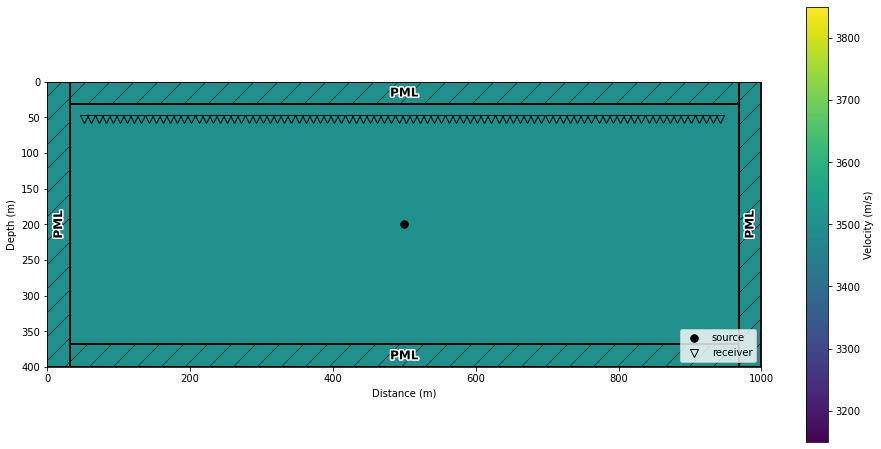

In [5]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seis.DrawDomain2D(model['vp'], ax = ax, showsrcrec = True, showabs = True)

## Defining the source signature

Once sources positions are defined, we need to define the source signature of each source. The array `SeisCL.src_all` contains the sources signature and has the format [NT X nb_srcs]. If not defined, `SeisCL` will fill thay array automatically, with a Ricker wavelet with a central frequency of `seis.f0`. For now, the attribute `SeisCL.src_all` is empty:

In [6]:
print(seis.src_all)

None


Upon calling `SeisCL.set_forward`, the src signature is filled up with a Ricker Wavelet

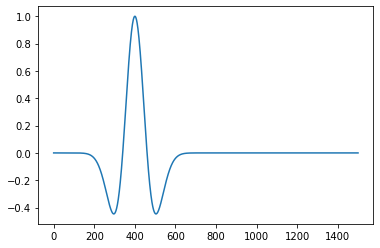

In [7]:
seis.set_forward([0], model, withgrad=False)
plt.plot(seis.src_all)

If another source function is needed, we can always redefine `src_all` to whatever we would like. 

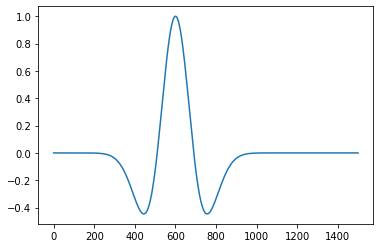

In [8]:
seis.src_all[:, 0] = seis.ricker_wavelet(f0=seis.f0/1.5)
plt.plot(seis.src_all)

Once src_all is defined, the `SeisCL.set_forward` method does not overwrite it:

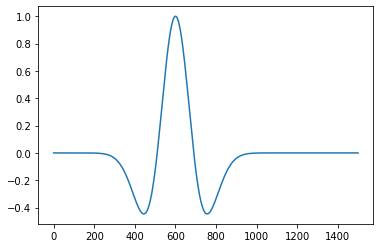

In [9]:
seis.set_forward([0], model, withgrad=False)
plt.plot(seis.src_all)

 ## Performing the simulation
 
 We now have everything we need, so we can run the simulation and show the result.

In [10]:
seis.seisout = 2
seis.set_forward([0], model, withgrad=False)
seis.execute()
data = seis.read_data()[0]

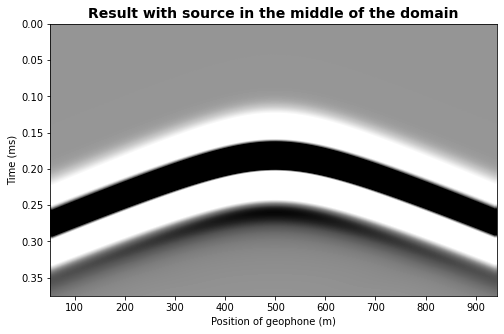

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5])
extent = [seis.rec_pos_all[0,0], seis.rec_pos_all[0,-1], seis.NT*dt, 0]
clip = 0.1
vmax = np.max(data) * clip
vmin = -vmax
ax.imshow(data, aspect='auto', vmax=vmax, vmin=vmin,
          extent=extent, interpolation='bilinear',
          cmap=plt.get_cmap('Greys'))
ax.set_title("Result with source in the middle of the domain", fontsize=14, fontweight='bold')
ax.set_xlabel("Position of geophone (m)")
ax.set_ylabel("Time (ms)")
plt.show()

## Computing a selection over multiple shots

For now, we have only shown examples with one shot position. Let's now show how to have multiple shots, and compute only a subsample of them. This can be useful for stochastic optimization, as shown by [Fabien-Ouellet et al. ( 2017)](https://doi.org/10.1190/segam2017-17783222.1).

Let's define 4 shot positions.

In [12]:
seis.src_pos_all = np.empty((5, 0))
seis.rec_pos_all = np.empty((8, 0))
seis.src_all = None

sx = np.array([100, 200, 300, 400]) * dh
sy = sx * 0
sz = sx * 0 + Nz // 2 * dh
srcid = np.arange(0, len(sx))
src_type = sx * 0 + 100

seis.src_pos_all = np.stack([sx, sy, sz, srcid, src_type], axis=0)
print(seis.src_pos_all)

[[200 400 600 800]
 [  0   0   0   0]
 [200 200 200 200]
 [  0   1   2   3]
 [100 100 100 100]]


Let's reuse the same receiver position as the previous example. In this case, we have to repeat them for each shot.

In [13]:
gx4 = np.tile(gx, len(sx))
gy4 = np.tile(gy, len(sy))
gz4 = np.tile(gz, len(sz))
gsid4 = np.concatenate([gsid + ii for ii in range(len(sx))])
recid4 = np.arange(0, len(gx4)) + 1
blank4 = np.tile(blank, len(sx))

seis.rec_pos_all = np.stack([gx4, gy4, gz4, gsid4, recid4, blank4, blank4, blank4], axis=0)

Say we want to only compute shots 0 and 2. We can easily do that by passing that information to `set_forward`

In [14]:
seis.set_forward([0, 2], model, withgrad=False)
seis.execute()
data = seis.read_data()[0]

Note that data shape is [NT X ntraces], which means that all traces of all shots are concatenated in the same array. Let's resort according to the shot position.

In [15]:
data = np.reshape(data, [data.shape[0], -1, data.shape[1]//2])

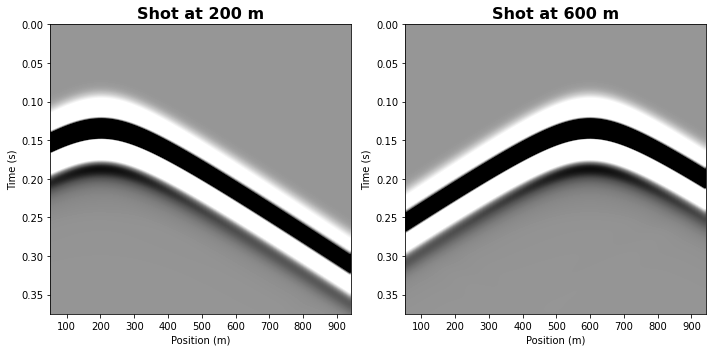

In [16]:
fig2 = plt.figure(figsize = (10,5))
ax2 = []
extent = [seis.rec_pos_all[0,0], seis.rec_pos_all[0, -1], seis.NT*dt, 0]
clip = 0.1

vmax = np.max(data) * clip
vmin = -vmax

for idx, shot in enumerate([0, 2]):
    
    ax2.append(fig2.add_subplot(1,2,idx+1))
    ax2[idx].imshow(data[:, idx, :], aspect='auto', vmax=vmax, vmin=vmin,
                    extent=extent, interpolation='bilinear',
                    cmap=plt.get_cmap('Greys'))
    ax2[idx].set_title('Shot at ' + str(sx[shot]) + ' m',
                       fontsize=16, fontweight='bold')
    ax2[idx].set_xlabel("Position (m)")
    ax2[idx].set_ylabel("Time (s)")

plt.tight_layout()

plt.show()

## Simultaneous shots

SeisCL also allows firing simultaneuously different shots. In fact, all shots sharing the same `srcid` are fired at the same time. 

Let's show that by redefining the source array. 

In [17]:
seis.src_pos_all[3, 1] = 0
seis.src_pos_all[3, 2] = 1
seis.src_pos_all[3, 3] = 1
print(seis.src_pos_all)

[[200 400 600 800]
 [  0   0   0   0]
 [200 200 200 200]
 [  0   0   1   1]
 [100 100 100 100]]


Similarly, we redefine the receiver positions.

In [18]:
gx2 = np.tile(gx, 2)
gy2 = np.tile(gy, 2)
gz2 = np.tile(gz, 2)
gsid2 = np.concatenate([gsid + ii for ii in range(2)])
recid2 = np.arange(0, len(gx2)) + 1
blank2 = np.tile(blank, 2)

seis.rec_pos_all = np.stack([gx2, gy2, gz2, gsid2, recid2, blank2, blank2, blank2], axis=0)

We then compute the shots for the srcids 0 and 1.

In [19]:
seis.set_forward([0, 1], model, withgrad=False)
seis.execute()
data = seis.read_data()[0]

Two acquisitons have been simulated, with two sources per acquisitions.

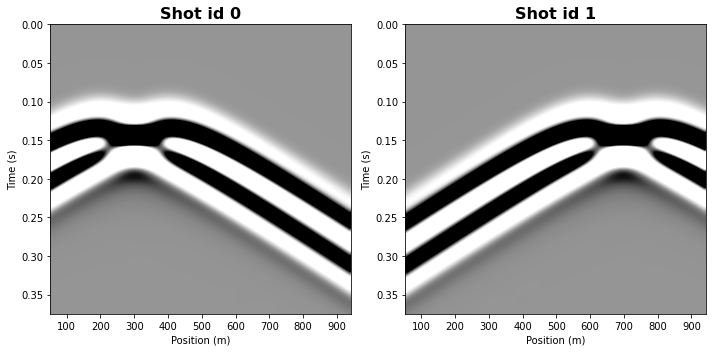

In [20]:
data = np.reshape(data, [data.shape[0], -1, data.shape[1]//2])
fig2 = plt.figure(figsize = (10,5))
ax2 = []
extent = [seis.rec_pos_all[0,0], seis.rec_pos_all[0, -1], seis.NT*dt, 0]
clip = 0.1

vmax = np.max(data) * clip
vmin = -vmax

for idx, shot in enumerate([0, 1]):
    
    ax2.append(fig2.add_subplot(1,2,idx+1))
    ax2[idx].imshow(data[:, idx, :], aspect='auto', vmax=vmax, vmin=vmin,
                    extent=extent, interpolation='bilinear',
                    cmap=plt.get_cmap('Greys'))
    ax2[idx].set_title('Shot id ' + str(shot),
                       fontsize=16, fontweight='bold')
    ax2[idx].set_xlabel("Position (m)")
    ax2[idx].set_ylabel("Time (s)")

plt.tight_layout()

plt.show()